In [1]:
import numpy as np
import time
import numpy.linalg as npl
import scipy as sp
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt
%pylab inline
from dolfin import *
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Définition des classes et paramètres

In [2]:
# Rayon du disque
r = 0.3

# Nombre de noeuds sur l'arête
N = 20

# Classes des domaines
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)
class Gamma0(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2 and (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2

# Initialize sub-domain instances
left   = Left()
top    = Top()
right  = Right()
bottom = Bottom()
gamma  = Gamma0()

# Define mesh
mesh = UnitSquareMesh(N,N)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)         #domains 0 = all space
gamma.mark(domains, 1)     #domains 1 = all gamma0

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) #1d domains
boundaries.set_all(0)      #boundaries 0 = all boundaries
left.mark(boundaries, 1)   #boundaries 1 = left (Neumann)
top.mark(boundaries, 2)    #boundaries 2 = top (Dirichlet)
right.mark(boundaries, 3)  #boundaries 3 = right (Neumann)
bottom.mark(boundaries, 4) #boundaries 4 = bottom (Neumann parametrized)

# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 0.0, boundaries, 2)]

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

## Solver du problème 2D

In [3]:
def Solver(mu):
    # Define input data
    mu0 = Constant(mu[0])  
    mu1 = Constant(mu[1])
    
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    def a1(mu0):
        return inner(mu0*grad(u),grad(v))*dx(1)
    a = a0 + a1(mu0) #+ inner(mu1*grad(u),grad(v))*ds(4)
    L0 = v*ds(4)
    L = mu1*L0
    
    # Passage en nd.array
    A = assemble(a)
    b = assemble(L)
    A2 = np.copy(A.array())
    b2 = np.copy(b.get_local())
    
    # Conditions de Dirichlet
    n=0
    niter=2
    for i in range((N+1)**2):
        for j in range((N+1)**2):
            if (i == n)and(i<=int((N+1)**2)/2):
                A2[i,:] = 0
                A2[i,i] = 1
                n += niter
                niter += 1
    
    # Résolution du système linéaire
    u2 = npl.solve(A2,b2)
    
    # Passage en dolfin.Function
    Sol = Function(V)
    Sol.vector().set_local(u2)
    #c = plot(Sol)
    #plt.colorbar(c)

    return np.array([Sol,A2,b2])

In [4]:
%%time
mu_test = np.array([10,0.1])
A = Solver(mu_test)[0]

CPU times: user 121 ms, sys: 672 µs, total: 122 ms
Wall time: 80.1 ms


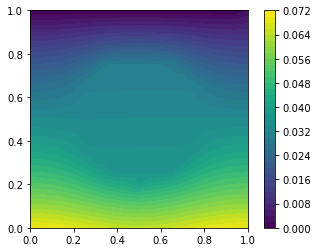

In [5]:
c = plot(A)
plt.colorbar(c)

In [6]:
print(A.vector().get_local().shape)

(441,)


## Offline procedure

In [7]:
def PODlight(total_model_solver,training_set,N,tol=1e-5):
    start = time.time()
    U,S,V = svd(U_delta.T)
    cumul_relat_vp = 0
    sum_vp = np.sum(S)
    for rank,vp in enumerate(S):
        cumul_relat_vp += vp/sum_vp
        if 1-cumul_relat_vp < tol:
            tronk_rank = rank
            break
    U_tr = U[:,:N]
    temps = start - time.time()
    return U_delta.dot(U_tr),temps,1-cumul_relat_vp

In [8]:
def svd(U_delta):
    """
    This is not a simple svd, it's a svd-based algorithm described in 
    "Linear algebra box: Proper Orthogonal Decomposition (POD)" p.33
    """
    N,M = U_delta.shape
    wU = U_delta/np.sqrt(M)
    U,s,V = npl.svd(wU,False)
    S = s**2
    return U,S,V

In [9]:
def training_set_creator(*args):
    """
    args are a non-zero number of lists of size 3.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "[a,b,c]" as a first argument.
    return: n-dimensional grid on which you can iterate.
    
    """
    linspace_args = (np.linspace(*arg) for arg in args)
    
    meshes = np.meshgrid(*linspace_args)
    dimensions = map(np.ravel, meshes)
#     dimensions = [mesh.ravel() for mesh in meshes]
    
    tuples = zip(*dimensions)
    return list(tuples)
#     for tup in tuples:
#         yield(tuple(tup))

In [10]:
def reduced_solver(mu,A_q,shape):
    """
    from output of pre_computer and a mu: computes A_rb and f_rb and u_rb, the solution of A_rb.u_rb=f_rb
    """
    A = np.copy(A_q[1])
    f = np.copy(A_q[3])
    for i in range(shape):
        A += A_q[0][i]*mu[i]
    for i in range(shape,len(mu)):
        f += A_q[2][i-shape]*mu[i]
    A1 = np.copy(A)
    f1 = np.copy(f)
    return npl.solve(A1,f1)

In [11]:
def pre_computer(Base):
    """
    pre_computer take as input a reduced_base and pre_computes all quantities used for a reduced_solver.
    output: [[A_rb^q](0<= i <=n1),A_rb^0,[f_rb^q](0<= i <=n2),f_rb^0],n
    with A_rb = sum_(i in 0..n1){ mu[i]*A_rb^(q_1)_i } + A_rb^0
    and  f_rb = sum_(i in n1+1..n2){ mu[i]*f_rb^(q_1)_i } + f_rb^0
            n = n1+1
    """
    #mu0 = Constant(mu[0])
    #mu1 = Constant(mu[1])
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    #def a1(mu0):
    #    return inner(grad(u),grad(v))*dx(1)
    a1 = inner(grad(u),grad(v))*dx(1)

    L0 = v*ds(4)
    #L = mu1*L0
    
    A_0M = assemble(a0)
    A_1M = assemble(a1)
    b = assemble(L0)
    A_0 = np.copy(A_0M.array())
    A_1 = np.copy(A_1M.array())
    b_0 = np.copy(b.get_local())
    #n=0
    #niter=2
    #for i in range((N+1)**2):
    #    for j in range((N+1)**2):
    #        if (i == n)and(i<=int((N+1)**2)/2):
    #            A_0[i,:] = 0
    #            A_0[i,i] = 1
    #            n += niter
    #            niter += 1
                
    
    A0B = [np.array(Base.T.dot(A_1.dot(Base)))]
    A1B = np.array(Base.T.dot(A_0.dot(Base)))
    b1 = [np.array(Base.T.dot(b_0))]
    b2 = np.array(Base.T.dot(np.zeros(b_0.shape)))
    
    #At = assemble(a0 + a1(mu0))
    #bt = assemble(L)
    #A = np.copy(At.array())
    #b = np.copy(bt.get_local())
    
    return [A0B,A1B,b1,b2],1 #[Base.T.dot(A.dot(Base)),Base.T.dot(b)],1

In [12]:
def greedylight(MUs,N,tol):
    start_time = time.time()
    U_delta_mu1 = np.copy(U_delta[:,0])
    rang = np.array(np.arange(0,U_delta.shape[1],1),'int')
    np.delete(rang,0)
    B = np.copy(np.array(U_delta_mu1)).reshape(len(np.array(U_delta_mu1)),1)
    err = 1e10
    n=1 
    while err > tol and len(rang) > 0 and n<N:
        eta = np.zeros(len(rang))
        for idx_mu, mu in enumerate(MUs):
            A_delta_mu = np.copy(A_delta[:,:,idx_mu])
            f_delta_mu = np.copy(F_delta[:,idx_mu])
            u_delta_mu = np.copy(U_delta[:,idx_mu])
            u_rb_mu = npl.solve(B.T.dot(A_delta_mu.dot(B)), B.T.dot(f_delta_mu))
            eta[idx_mu] = npl.norm(u_delta_mu - B.dot(u_rb_mu), ord=2)
        idx_worst_mu = np.argmax(eta)
        add = np.zeros((len(U_delta),1))
        add[:,0] = np.copy(U_delta[:,idx_worst_mu])
        add = add.T
        B = np.vstack((B.T,add/npl.norm(add))).T
        MUs.pop(idx_worst_mu)
        np.delete(U_delta, idx_worst_mu,axis=1)
        err = eta[idx_worst_mu]
        n += 1
    base = np.copy(B)
    temps = time.time() - start_time
    return base,temps,err

# Données

In [63]:
%%time
N_max_vectors = 1        #nombre max de vecteurs dans la base
N_training_set = 3      #taille du training set
tol = 1e-5               #tolérance max
T0 = np.array([1,10,N_training_set])
T1 = np.array([-1,1,N_training_set])
MUs = training_set_creator(T0,T1)

CPU times: user 521 µs, sys: 28 µs, total: 549 µs
Wall time: 490 µs


In [64]:
start_time = time.time()
U_delta = np.zeros((441,len(MUs)))
A_delta = np.zeros((441,441,len(MUs)))
F_delta = np.zeros((441,len(MUs)))
n = 0
for mu_loop in MUs:
    U,A,F = Solver(mu_loop)
    A_delta[:,:,n] = A
    F_delta[:,n] = F
    U_delta[:,n] = U.vector().get_local()
    n+=1
temps = time.time() - start_time

In [65]:
print(temps)

0.5946900844573975


In [46]:
BaseG,tempsG,errorG = greedylight(MUs,N=2,tol=1e-5)
print(BaseG.shape)
print(errorG)
print(tempsG)

9


IndexError: pop from empty list

In [107]:
Base5,tempsP,errorP = PODlight(Solver,MUs,5)
print(BaseP.shape)
print(tempsP)
print(errorP)

(441, 5)
-0.07399296760559082
5.913692101566781e-07


In [110]:
Base4,tempsP,errorP = PODlight(Solver,MUs,4)
print(Base4.shape)
print(tempsP)
print(errorP)

(441, 4)
-0.0749664306640625
5.913692101566781e-07


In [207]:
print(npl.norm(Base))
print(npl.norm(Base2))

108.7514411500097
108.7514411500097


In [102]:
Base, temps, err = greedylight(MUs,N=i,tol=1e-5)
nb_vecteurs_base += [Base.shape[1]]
temps_base += [temps]
err_base += [err]
A_q,shape = pre_computer(Base)
T0 = np.array([1,10,10])
T1 = np.array([-1,1,10])
eval_set  = training_set_creator(T0,T1)
errors = []
times = []
for mu in eval_set:
    U_true = Solver(mu)[0]
    start_time = time.time()
    print(mu)
    U_rb = np.copy(reduced_solver(mu,np.array(A_q),shape))
    times += [time.time() - start_time]
    RES = Base.dot(U_rb)

(1.0, -1.0)
<class 'numpy.ndarray'>
(2.0, -1.0)
<class 'numpy.ndarray'>
(3.0, -1.0)
<class 'numpy.ndarray'>
(4.0, -1.0)
<class 'numpy.ndarray'>
(5.0, -1.0)
<class 'numpy.ndarray'>
(6.0, -1.0)
<class 'numpy.ndarray'>
(7.0, -1.0)
<class 'numpy.ndarray'>
(8.0, -1.0)
<class 'numpy.ndarray'>
(9.0, -1.0)
<class 'numpy.ndarray'>
(10.0, -1.0)
<class 'numpy.ndarray'>


LinAlgError: Singular matrix

In [100]:
N = 3
tol = 1e-5

### Création de la base

In [104]:
C = []
A = [1,4,6]
C.append(A)
B = [5,0,0]
C.append(B)
print(np.array(C))
print(C[0])

[[1 4 6]
 [5 0 0]]
[1, 4, 6]


In [15]:
onl_err_mean_geng = []
onl_err_max_geng = []
onl_err_med_geng = []
onl_tps_mean_geng = []
onl_tps_max_geng = []
onl_tps_med_geng = []
temps_base_geng = []
err_base_geng = []
nb_vecteurs_base_geng = []
onl_err_mean_genp = []
onl_err_max_genp = []
onl_err_med_genp = []
onl_tps_mean_genp = []
onl_tps_max_genp = []
onl_tps_med_genp = []
temps_base_genp = []
err_base_genp = []
nb_vecteurs_base_genp = []
tru_tps_mean_gen = []
tru_tps_max_gen = []
tru_tps_med_gen = []

for J in [10]:
    print("Taille du training set : ",J)
    N_training_set = J       #taille du training set
    tol = 1e-5               #tolérance max
    T0 = np.array([1,10,N_training_set])
    T1 = np.array([-1,1,N_training_set])
    MUs = training_set_creator(T0,T1)
    start_time = time.time()
    U_delta = np.zeros((441,len(MUs)))
    A_delta = np.zeros((441,441,len(MUs)))
    F_delta = np.zeros((441,len(MUs)))
    n = 0
    for mu_loop in MUs:
        U,A,F = Solver(mu_loop)
        A_delta[:,:,n] = A
        F_delta[:,n] = F
        U_delta[:,n] = U.vector().get_local()
        n+=1
    temps = time.time() - start_time
    onl_err_meang = []
    onl_err_maxg = []
    onl_err_medg = []
    onl_tps_meang = []
    onl_tps_maxg = []
    onl_tps_medg = []
    temps_baseg = []
    err_baseg = []
    nb_vecteurs_baseg = []
    onl_err_meanp = []
    onl_err_maxp = []
    onl_err_medp = []
    onl_tps_meanp = []
    onl_tps_maxp = []
    onl_tps_medp = []
    tru_tps_max = []
    tru_tps_med = []
    tru_tps_mean = []
    temps_basep = []
    err_basep = []
    nb_vecteurs_basep = []
    for i in [1,2,3,4,5,6]:
        print("Taille max de la base : ",i)
        #MUs = training_set_creator(T0,T1)
        Baseg, tempsg, errg = greedylight(MUs,N=i,tol=1e-5)
        #MUs = training_set_creator(T0,T1)
        Basep, tempsp, errp = PODlight(Solver,MUs,N=i)
        nb_vecteurs_basep += [Basep.shape[1]]
        nb_vecteurs_baseg += [Baseg.shape[1]]
        temps_baseg += [tempsg]
        temps_basep += [tempsp]
        err_baseg += [errg]
        err_basep += [errp]
        A_qg,shapeg = pre_computer(Baseg)
        A_qp,shapep = pre_computer(Basep)
        T0 = np.array([1,10,10])
        T1 = np.array([-1,1,10])
        eval_set  = training_set_creator(T0,T1)
        errorsp = []
        timesp = []
        errorsg = []
        timesg = []
        timest = []
        for mu in eval_set:
            A_qg,shapeg = pre_computer(Baseg)
            A_qp,shapep = pre_computer(Basep)
            vraitemps = time.time()
            U_true = Solver(mu)[0]
            timest += [time.time()-vraitemps]
            start_time = time.time()
            U_rbg = reduced_solver(mu,A_qg,shapeg)
            timesg += [time.time() - start_time]
            start_time = time.time()
            U_rbp = reduced_solver(mu,A_qp,shapep)
            timesp += [time.time() - start_time]
            RESg = Baseg.dot(U_rbg)
            RESp = Basep.dot(U_rbp)
            errorsg += [(npl.norm(U_true.vector().get_local()-RESg))/npl.norm(U_true.vector())]
            errorsp += [(npl.norm(U_true.vector().get_local()-RESp))/npl.norm(U_true.vector())]
            #print(mu)
            #print(npl.norm(U_true.vector()))
        onl_err_meang += [np.mean(errorsg)]
        onl_err_maxg += [np.max(errorsg)]
        onl_err_medg +=[np.median(errorsg)]
        onl_tps_meang += [np.mean(timesg)]
        onl_tps_maxg += [np.max(timesg)]
        onl_tps_medg += [np.median(timesg)]
        temps_baseg += [tempsg]
        err_baseg += [errg]
        nb_vecteurs_baseg += [np.shape(Baseg)[1]]
        onl_err_meanp += [np.mean(errorsp)]
        onl_err_maxp += [np.max(errorsp)]
        onl_err_medp +=[np.median(errorsp)]
        onl_tps_meanp += [np.mean(timesp)]
        onl_tps_maxp += [np.max(timesp)]
        onl_tps_medp += [np.median(timesp)]
        temps_basep += [tempsp]
        err_basep += [errp]
        nb_vecteurs_basep += [np.shape(Basep)[1]]
        tru_tps_mean += [np.mean(timest)]
        tru_tps_max += [np.max(timest)]
        tru_tps_med += [np.median(timest)]
    onl_err_mean_geng += [onl_err_meang]
    onl_err_max_geng += [onl_err_maxg]
    onl_err_med_geng +=[onl_err_medg]
    onl_tps_mean_geng += [onl_tps_meang]
    onl_tps_max_geng += [onl_tps_maxg]
    onl_tps_med_geng += [onl_tps_medg]
    temps_base_geng += [temps_baseg]
    err_base_geng += [err_baseg]
    nb_vecteurs_base_geng += [nb_vecteurs_baseg]
    onl_err_mean_genp += [onl_err_meanp]
    onl_err_max_genp += [onl_err_maxp]
    onl_err_med_genp +=[onl_err_medp]
    onl_tps_mean_genp += [onl_tps_meanp]
    onl_tps_max_genp += [onl_tps_maxp]
    onl_tps_med_genp += [onl_tps_medp]
    tru_tps_mean_gen += [tru_tps_mean]
    tru_tps_max_gen += [tru_tps_max]
    tru_tps_med_gen += [tru_tps_med]
    temps_base_genp += [temps_basep]
    err_base_genp += [err_basep]
    nb_vecteurs_base_genp += [nb_vecteurs_basep]

Taille du training set :  10
Taille max de la base :  1
Taille max de la base :  2
Taille max de la base :  3
Taille max de la base :  4
Taille max de la base :  5
Taille max de la base :  6


In [21]:
print(np.array(onl_tps_mean_genp))

[[8.91637802e-05 8.98075104e-05 8.79287720e-05 8.88848305e-05
  8.92663002e-05 8.93878937e-05]]


In [23]:
print(np.array(tru_tps_max_gen))

[[0.07299924 0.04999566 0.03876042 0.0398562  0.05928469 0.0867939 ]]


In [22]:
print(np.array(tru_tps_mean)/np.array(onl_tps_mean_genp))

[[416.37812182 413.24352235 417.05124729 412.78289209 412.58403889
  418.48615705]]


In [14]:
print(np.array(onl_tps_max_genp))

[[0.0001173  0.00044775 0.00012493 0.00012183 0.0001204  0.00010228]]


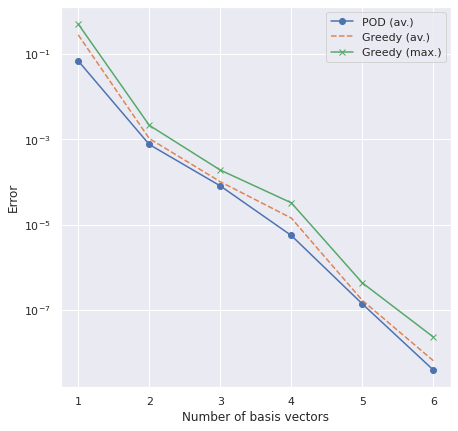

In [120]:
sns.set()
fig = plt.figure()
fig.set_size_inches(7,7)
plt.plot([1,2,3,4,5,6],(np.array(onl_err_mean_genp[0][:])),"-o",label="POD (av.)")
plt.plot([1,2,3,4,5,6],(np.array(onl_err_mean_geng[0][:])),"--",label="Greedy (av.)")
plt.plot([1,2,3,4,5,6],(np.array(onl_err_max_geng[0][:])),"-x",label="Greedy (max.)")
plt.ylabel("Error")
plt.xlabel("Number of basis vectors")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.savefig("PODvsGreedy-erroronline-nb_base.png")
plt.show()

In [93]:
p = onl_err_max_genp[0][-1]
print(p)
g = onl_err_max_geng[0][-1]
print(g)
pourcent = (g)/p
print(pourcent)
print(pourcent*p)
print("Greedy")

8.402487375596011e-09
2.286176453054808e-08
2.7208329520312353
2.286176453054808e-08


In [96]:
print(onl_err_max_genp[0])

[0.15737422608895407, 0.0013610210223408625, 0.00016808422410014175, 1.0396998251852304e-05, 2.5809443797110623e-07, 8.402487375596011e-09]


In [102]:
print(onl_err_max_geng[0])

[0.5079613330638042, 0.002134942636756886, 0.00018973591313904415, 3.2349519242738593e-05, 4.265252784370629e-07, 2.286176453054808e-08]


In [105]:
print(np.mean(np.array(onl_err_max_geng[0])/np.array(onl_err_max_genp[0])))
print(np.median(np.array(onl_err_max_geng[0])/np.array(onl_err_max_genp[0])))

2.2350053401363517
2.18671339622436


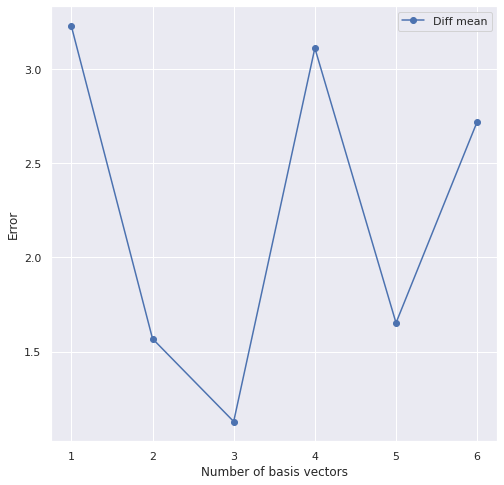

In [95]:
fig = plt.figure()
fig.set_size_inches(8,8)
plt.plot([1,2,3,4,5,6],np.abs(np.array(onl_err_max_geng[0][:]))/np.abs(np.array(onl_err_max_genp[0])),"-o",label="Diff mean")
plt.ylabel("Error")
plt.xlabel("Number of basis vectors")
plt.yscale("linear")
plt.legend()
plt.grid(True)
plt.savefig("PODvsGreedy-erroronline-nb_base.png")
plt.show()

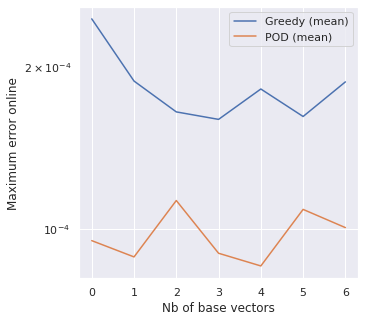

In [140]:
fig = plt.figure()
fig.set_size_inches(5,5)
plt.plot(np.array([0,1,2,3,4,5,6]),(np.array(onl_tps_mean_geng)[0,:]),label="Greedy (mean)")
plt.plot(np.array([0,1,2,3,4,5,6]),(np.array(onl_tps_mean_genp)[0,:]),label="POD (mean)")
plt.ylabel("Maximum error online")
plt.xlabel("Nb of base vectors")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

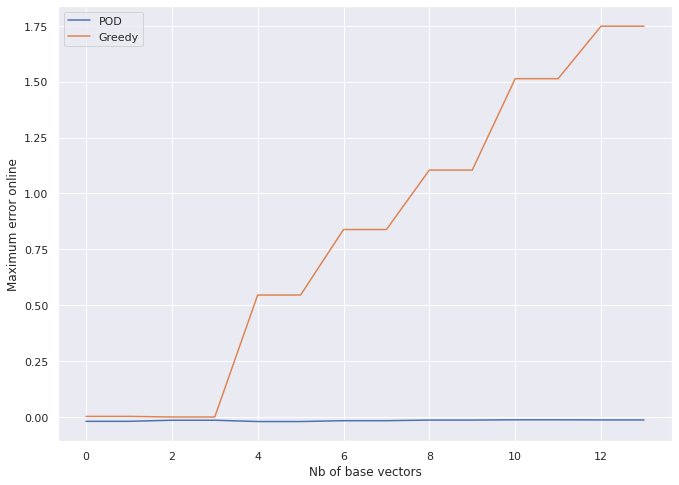

In [141]:
fig = plt.figure()
fig.set_size_inches(11,8)
plt.plot((np.array(temps_base_genp)[-1,:]),label="POD")
plt.plot((np.array(temps_base_geng)[-1,:]),label="Greedy")
plt.ylabel("Maximum error online")
plt.xlabel("Nb of base vectors")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
print(onl_err_max_genp)

[[nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan]]


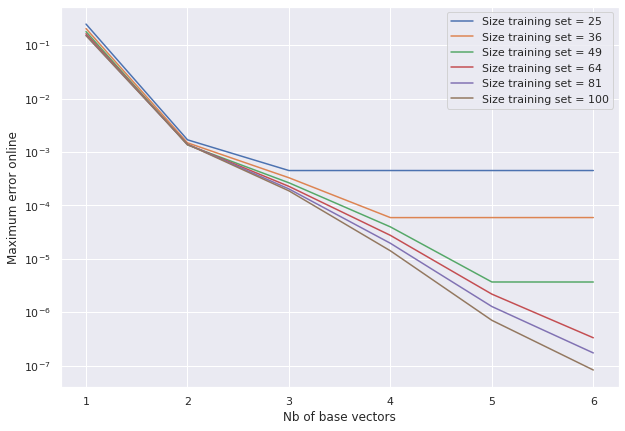

In [50]:
sns.set()
fig = plt.figure()
fig.set_size_inches(10,7)
for i in [0,1,2,3,4,5]:
    plt.plot([1,2,3,4,5,6],(onl_err_max_genp[i]),label="Size training set = {0}".format((i+5)**2))
plt.yscale("log")
plt.ylabel("Maximum error online")
plt.xlabel("Nb of base vectors")
plt.legend()
plt.grid(True)
plt.show()
## with minimal accuracy of 1e-5

In [45]:
onl_err_mean_gen += [onl_err]
onl_err_max_gen += [onl_err_max]
onl_err_med_gen +=[onl_err_med]
onl_tps_mean_gen += [onl_tps_mean]
onl_tps_max_gen += [onl_tps_max]
onl_tps_med_gen += [onl_tps_med]

NameError: name 'onl_err_mean_gen' is not defined

### Truth solution for mu_test & évaluation du temps mis

In [116]:
%%time
A_q,shape = pre_computer(Base4)

CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 24.7 ms


In [117]:
%%timeit
Urb = reduced_solver(np.array([6,0.1]),A_q,shape)
U = Base4.dot(Urb)

58.6 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [118]:
%%time
A_q,shape = pre_computer(Base5)

CPU times: user 14.7 ms, sys: 12.1 ms, total: 26.9 ms
Wall time: 36.5 ms


In [119]:
%%timeit
Urb = reduced_solver(np.array([6,0.1]),A_q,shape)
U = Base5.dot(Urb)

56.3 µs ± 773 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
T0 = np.array([1,10,10])
T1 = np.array([-1,1,10])
eval_set  = training_set_creator(T0,T1)
errors = []
times = []
for mu in eval_set:
    U_true = Solver(mu)[0]
    start_time = time.time()
    U_rb = reduced_solver(mu,A_q,shape)
    times += [time.time() - start_time]
    print(times[-1])
    RES = Base.dot(U_rb)
    errors += [(npl.norm(U_true.vector().get_local()-RES))/npl.norm(U_true.vector())]
print("Mean   : ", np.mean(errors))
print("Max    : ", np.max(errors))
print("Median : ", np.median(errors))
print("Mean   : ", np.mean(times))
print("Max    : ", np.max(times))
print("Median : ", np.median(times))

0.00015282630920410156
0.000152587890625
0.0001533031463623047
0.00015497207641601562
0.00015473365783691406
0.00017690658569335938
0.0001685619354248047
0.0001537799835205078
0.000164031982421875
0.00016021728515625
0.00016069412231445312
0.00015425682067871094
0.00015354156494140625
0.00018787384033203125
0.0001552104949951172
0.0001552104949951172
0.00015282630920410156
0.00016427040100097656
0.0001552104949951172
0.00015807151794433594
0.00015544891357421875
0.000217437744140625
0.0002238750457763672
0.00015687942504882812
0.00015807151794433594
0.0001544952392578125
0.0001556873321533203
0.0001556873321533203
0.000164031982421875
0.0001556873321533203
0.00015854835510253906
0.0001823902130126953
0.00016045570373535156
0.00020503997802734375
0.0001811981201171875
0.00017380714416503906
0.0061838626861572266
0.0001838207244873047
0.0001957416534423828
0.0001761913299560547
0.00026869773864746094
0.00015473365783691406
0.00016355514526367188
0.00015592575073242188
0.00015878677368164

In [35]:
print("Mean   : ", np.mean(errors))
print("Max    : ", np.max(errors))
print("Median : ", np.median(errors))

Mean   :  0.29761408350532365
Max    :  0.5286617675609915
Median :  0.3269408035978465
